In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import plot_series

/home/hasi/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-01-26 15:32:54.580463: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 15:32:54.702271: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 15:32:54.702347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 15:32:54.722652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS

In [22]:
n_run = 2

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# You can define a folder name like 'output'
output_folder = "results"

# This creates the full path to the output directory
output_dir = os.path.join(current_dir, output_folder)

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


In [3]:
import matplotlib.pyplot as plt

def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None):
    """
    Visualizes time series data and returns the figure object.
    """
    # Create a figure object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:
        # Loop over the y elements
        for y_curr in y:
            # Plot the x and current y values
            ax.plot(x[start:end], y_curr[start:end], format)
    else:
        # Plot the x and y values
        ax.plot(x[start:end], y[start:end], format)

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Set the legend
    if legend:
        ax.legend(legend)

    # Overlay a grid
    ax.grid(True)

    # Return the figure object
    return fig


In [4]:
data = pd.read_csv('/home/hasi/Documents/data science/time_series/Timeseries-sunspots/sunspot_data.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73718 entries, 0 to 73717
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                73718 non-null  int64  
 1   Year                      73718 non-null  int64  
 2   Month                     73718 non-null  int64  
 3   Day                       73718 non-null  int64  
 4   Date In Fraction Of Year  73718 non-null  float64
 5   Number of Sunspots        73718 non-null  int64  
 6   Standard Deviation        73718 non-null  float64
 7   Observations              73718 non-null  int64  
 8   Indicator                 73718 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 5.1 MB


In [5]:
# Removing dates with nNumber of sunspots < 0.
data = data[ data['Number of Sunspots'] > 0]

group2 = data.groupby([data['Year'].astype(int),data['Month'].astype(int)]).mean()

sunspots = np.array(group2['Number of Sunspots'].astype(int))
time_step = np.array(group2['Date In Fraction Of Year'])

time = np.arange(sunspots.size)
series = np.array(sunspots)

<Figure size 640x480 with 0 Axes>

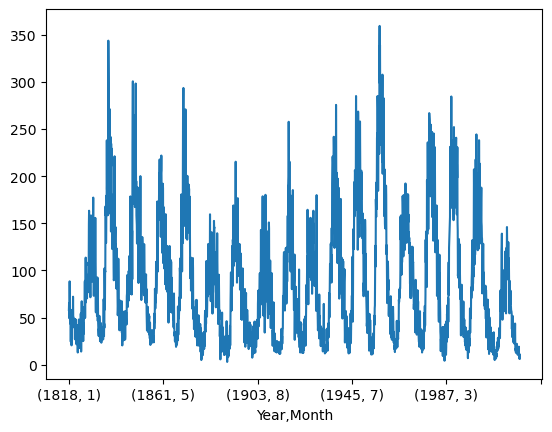

In [6]:
plt.figure()
group2.plot(y = 'Number of Sunspots',legend=False)
plt.show()

In [7]:
# Define the split time
split_time = 2000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

year_val = time_step[split_time:]

In [8]:
def data_window(data_ar, window_size, batch_size, shuffle_buffer):
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(data_ar)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset
    

In [9]:
# Parameters
window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = data_window(x_train, window_size, batch_size, shuffle_buffer_size)

## New Loss Function

In [10]:
class directional(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        true_diff = y_true[:-1] - y_true[1:]
        pred_diff = y_true[:-1] - y_pred[1:]
        
        true_sign = tf.sign(true_diff)
        pred_sign = tf.sign(pred_diff)
        return tf.keras.losses.mean_absolute_error(true_sign, pred_sign)

In [11]:
# new loss function.

def custom_loss(y_true, y_pred):
    # 1. Huber Loss
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    huber_loss = tf.keras.losses.Huber()(y_true, y_pred)

    # 2. Calculate Maxima and Minima Indices
    # Assuming y_true and y_pred are 1D time series. Adjust if they are not.
    true_max_idx = tf.argmax(y_true, axis=0)
    true_min_idx = tf.argmin(y_true, axis=0)
    pred_max_idx = tf.argmax(y_pred, axis=0)
    pred_min_idx = tf.argmin(y_pred, axis=0)

    max_diff = tf.cast(tf.abs(true_max_idx - pred_max_idx), tf.float32)
    min_diff = tf.cast(tf.abs(true_min_idx - pred_min_idx), tf.float32)
    date_discrepancy_term = max_diff + min_diff

    # 4. Combine the Losses
    return huber_loss + date_discrepancy_term



In [12]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [13]:
init_weights = model.get_weights()

In [14]:
from tqdm.keras import TqdmCallback

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=custom_loss, optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule,TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

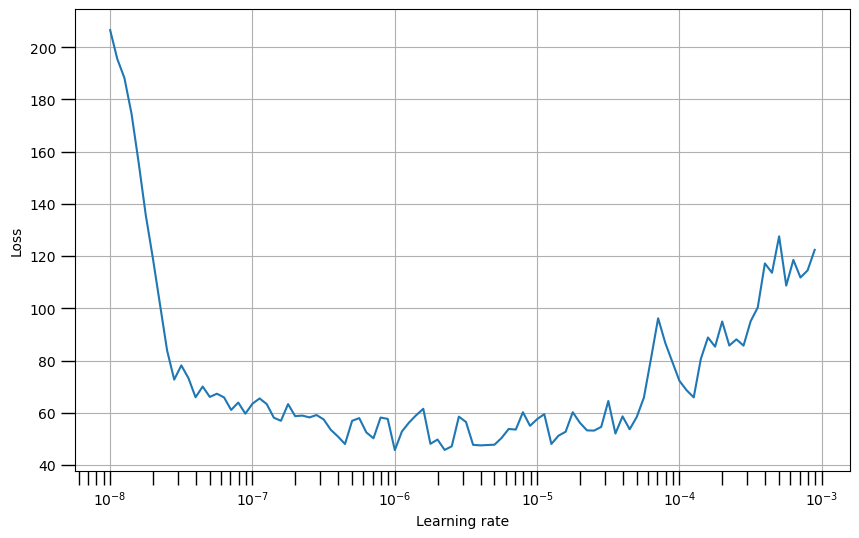

In [15]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
fig = plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

fig.savefig('directional_loss-vs-epoch_lossfn2.png',\
           dpi=600,format='png',bbox_inches='tight')
# Set the plot boundaries
#plt.axis([1e-8, 1e-3, 0, 100])
fig.savefig(output_dir+'/lossfn2_loss-learning_rate.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

# Fitting the Model

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [17]:
# Set the learning rate
learning_rate = 3e-6  # Chosen from the Loss vs Learning rate plot

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=custom_loss,
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
from tqdm.keras import TqdmCallback

n_epoch = 1500
# Train the model
history = model.fit(train_set,epochs=n_epoch, verbose=0,callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

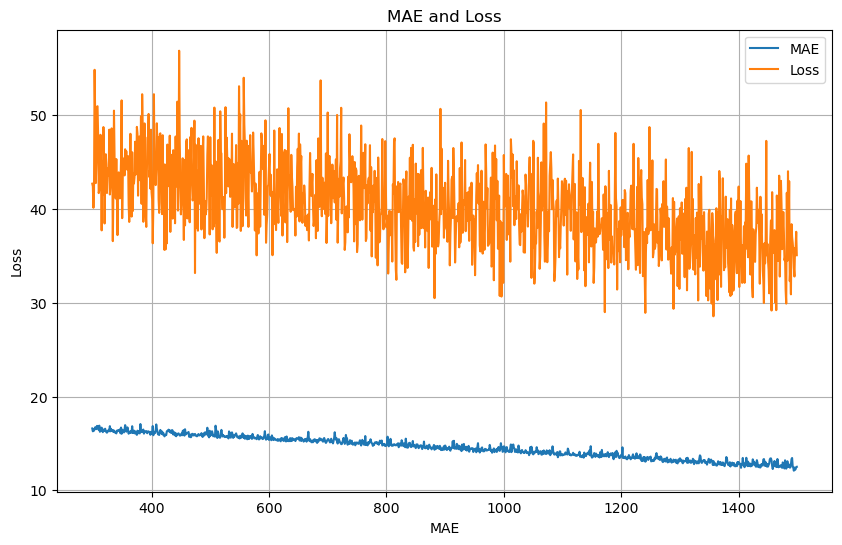

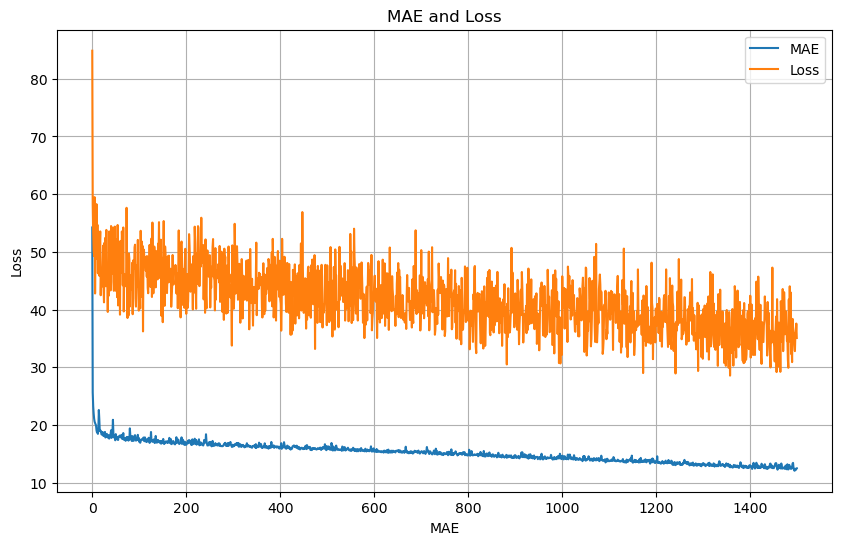

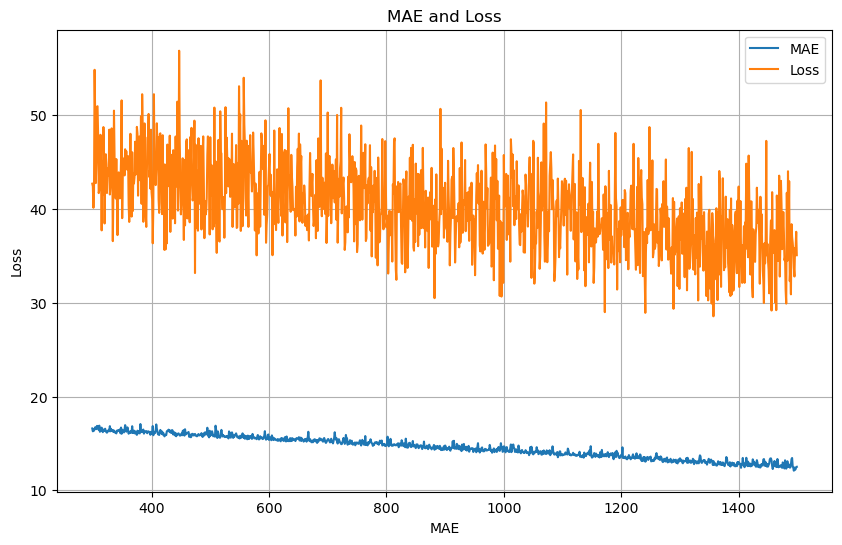

In [19]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

In [ ]:
plt.plot(loss[zoom_split:])

# Model Prediction

In [20]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

7/7 [==============================] - 0s 12ms/step


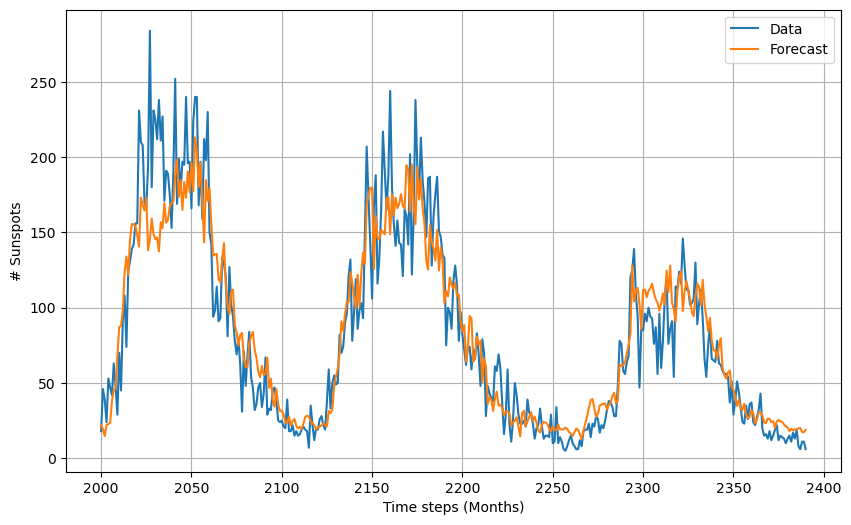

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
fig = plot_series(time_valid, (x_valid, results), xlabel='Time steps (Months)', 
            ylabel='# Sunspots', legend=['Data','Forecast'])

fig.savefig(output_dir+'/lossfn2_loss-predictions_epoch1500.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

In [20]:
output_dir+'/directional_loss-predictions_epoch500.png'

'/home/hasi/Documents/data science/time_series/Timeseries-sunspots/results/directional_loss-predictions_epoch500.png'

In [25]:
model.save(output_dir+'model%i_parameters.h5'%n_run)

In [24]:
import h5py

with h5py.File('model%i_parameters.h5'%n_run, 'a') as f:
    f.attrs['window_size'] = window_size   # Replace with your actual window size
    f.attrs['batch_size'] = batch_size   # Replace with your actual batch size